In [ ]:
# 1. Upload Data File in Colab
from google.colab import files
uploaded = files.upload()
import pandas as pd
import numpy as np

# Read the uploaded CSV file
df = pd.read_csv(list(uploaded.keys())[0])

Saving Data.csv to Data.csv


In [ ]:
# ---------------------------
# BLOCK 1: Imports & Config
# ---------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# Add to BLOCK 1
np.random.seed(42)
tf.random.set_seed(42)

# Configure plot appearance to match paper style
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams['figure.figsize'] = (10, 6)


In [ ]:
# ---------------------------
# BLOCK 2: Data Preparation
# ---------------------------
# Load dataset
data = pd.read_csv("Data.csv")

# Calculate resonance wavelength (wavelength with maximum loss for each RI)
res_wavelengths = data.groupby('RI')['core loss'].idxmax()
resonance_df = data.loc[res_wavelengths][['RI', 'wl[um]']].rename(
    columns={'wl[um]': 'resonance_wavelength'})

# Merge with original data
full_data = pd.merge(data, resonance_df, on='RI')

# Select features and targets
features = ['RI', 'wl[um]', 'Neff(real)', 'tg[um]', 'tgr[um]', 'A[um]', 'dc[um]']
X = full_data[features]
y = full_data[['core loss', 'resonance_wavelength']].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# ---------------------------
# BLOCK 3: Model Definitions
# ---------------------------
# Define all 8 models
models = {
    "MLR": MultiOutputRegressor(LinearRegression()),
    "SVR": MultiOutputRegressor(SVR()),
    "KNNR": MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5)),
    "DecisionTree": MultiOutputRegressor(DecisionTreeRegressor(random_state=42)),
    "RFR": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "GradientBoost": MultiOutputRegressor(GradientBoostingRegressor(loss='squared_error')),
    "XGBoost": MultiOutputRegressor(XGBRegressor(objective='reg:squarederror'))
}

# Define ANN model function for different layer configurations
def create_ann_model(input_shape, num_layers=3, activation='relu'):
    model = Sequential()
    model.add(Dense(64, activation=activation, input_shape=(input_shape,)))

    for _ in range(num_layers - 1):
        model.add(Dense(64, activation=activation))

    model.add(Dense(2))  # 2 outputs: core loss and resonance wavelength
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model


In [ ]:
# ---------------------------
# BLOCK 4: Training & 10-Fold CV
# ---------------------------
results = {}

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

# Train traditional models
print("Training traditional ML models...")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Store results
    results[name] = {
        "model": model,
        "predictions": y_pred,
        "metrics": calculate_metrics(y_test, y_pred)
    }

    # Generate 10-fold CV tables
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled), 1):
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Train and evaluate
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)

        # Calculate metrics
        metrics = calculate_metrics(y_fold_val, y_fold_pred)
        metrics["Fold"] = fold
        fold_results.append(metrics)

    # Create DataFrame with average row
    cv_df = pd.DataFrame(fold_results)
    avg_metrics = cv_df.drop("Fold", axis=1).mean().to_dict()
    avg_metrics["Fold"] = "Average"
    cv_df = pd.concat([cv_df, pd.DataFrame([avg_metrics])], ignore_index=True)

    results[name]["cv_table"] = cv_df

    # Display 10-fold CV table
    print(f"\n10-Fold Cross-Validation Table for {name}:")
    print(cv_df)


Training traditional ML models...

10-Fold Cross-Validation Table for MLR:
           MSE       RMSE        MAE        R²     Fold
0   225.000010  15.000000   7.539062  0.624028        1
1   151.857449  12.323045   6.425049  0.640797        2
2   332.061994  18.222568   7.868030  0.590215        3
3   603.189331  24.559913   9.346125  0.616263        4
4   871.175509  29.515682  11.869923  0.610561        5
5   321.600958  17.933236   9.250364  0.631875        6
6   787.065205  28.054682  10.290323  0.588658        7
7   262.225197  16.193369   8.244945  0.427565        8
8   967.847354  31.110245  11.622938  0.604439        9
9   777.405074  27.881985  10.720447  0.576636       10
10  529.942808  22.079473   9.317720  0.591104  Average

10-Fold Cross-Validation Table for SVR:
            MSE       RMSE        MAE        R²     Fold
0    245.156010  15.657459   5.677419  0.496135        1
1    175.018422  13.229453   5.720328  0.496931        2
2    380.941525  19.517723   6.814655  0.

In [ ]:
# ---------------------------
# BLOCK 5: ANN Training with Layer Analysis
# ---------------------------
# Train ANN with different layer configurations
layer_configs = [1, 2, 3]  # Test 1, 2, and 3 hidden layers
layer_histories = {}

print("\nTraining ANN with different layer configurations...")
for num_layers in layer_configs:
    # Create and train model
    ann_model = create_ann_model(X_train_scaled.shape[1], num_layers=num_layers)
    history = ann_model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=350,
        batch_size=32,
        verbose=0
    )

    # Evaluate and save results
    y_pred = ann_model.predict(X_test_scaled)
    layer_histories[num_layers] = {
        "model": ann_model,
        "history": history,
        "predictions": y_pred,
        "metrics": calculate_metrics(y_test, y_pred)
    }

    print(f"ANN with {num_layers} layer(s) - R²: {layer_histories[num_layers]['metrics']['R²']:.4f}")

# Generate 10-fold CV for best ANN configuration
best_layers = max(layer_configs, key=lambda x: layer_histories[x]['metrics']['R²'])
ann_cv_results = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled), 1):
    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    # Train and evaluate
    ann_model = create_ann_model(X_train_scaled.shape[1], num_layers=best_layers)
    ann_model.fit(X_fold_train, y_fold_train, epochs=150, batch_size=32, verbose=0)
    y_fold_pred = ann_model.predict(X_fold_val)

    # Calculate metrics
    metrics = calculate_metrics(y_fold_val, y_fold_pred)
    metrics["Fold"] = fold
    ann_cv_results.append(metrics)

# Create DataFrame with average row
ann_cv_df = pd.DataFrame(ann_cv_results)
avg_metrics = ann_cv_df.drop("Fold", axis=1).mean().to_dict()
avg_metrics["Fold"] = "Average"
ann_cv_df = pd.concat([ann_cv_df, pd.DataFrame([avg_metrics])], ignore_index=True)

results["ANN"] = {
    "model": layer_histories[best_layers]["model"],
    "predictions": layer_histories[best_layers]["predictions"],
    "metrics": layer_histories[best_layers]["metrics"],
    "cv_table": ann_cv_df,
    "layer_histories": layer_histories
}

print("\n10-Fold Cross-Validation Table for ANN:")
print(ann_cv_df)



Training ANN with different layer configurations...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
ANN with 1 layer(s) - R²: 0.7136


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
ANN with 2 layer(s) - R²: 0.8610


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ANN with 3 layer(s) - R²: 0.8093


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

10-Fold Cross-Validation Table for ANN:
           MSE       RMSE       MAE        R²     Fold
0    85.305336   9.236089  3.906115  0.728177        1
1    96.314440   9.813992  4.416007  0.660080        2
2   163.048657  12.769051  5.030479  0.408950        3
3   335.655092  18.320892  6.203744  0.638333        4
4   470.872390  21.699594  7.303763  0.596087        5
5   160.968325  12.687329  6.236090  0.476027        6
6   514.014492  22.671888  7.028082  0.687564        7
7   166.474875  12.902514  5.492186  0.333235        8
8   580.640117  24.096475  7.836421  0.709983        9
9   466.604805  21.601037  7.056659  0.285628       10
10  303.989853  16.579886  6.050955  0.552407  Average


In [ ]:
# ---------------------------
# BLOCK 6: ANN Activation Function Analysis
# ---------------------------
# Test different activation functions
activation_functions = ['relu', 'tanh', 'sigmoid']
activation_histories = {}

print("\nTraining ANN with different activation functions...")
for activation in activation_functions:
    # Create and train model with 3 layers
    model = Sequential([
        Dense(64, activation=activation, input_shape=(X_train_scaled.shape[1],)),
        Dense(64, activation=activation),
        Dense(64, activation=activation),
        Dense(2)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=150,
        batch_size=32,
        verbose=0
    )

    # Evaluate and save results
    y_pred = model.predict(X_test_scaled)
    activation_histories[activation] = {
        "model": model,
        "history": history,
        "predictions": y_pred,
        "metrics": calculate_metrics(y_test, y_pred)
    }

    print(f"ANN with {activation} activation - R²: {activation_histories[activation]['metrics']['R²']:.4f}")

results["ANN"]["activation_histories"] = activation_histories



Training ANN with different activation functions...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
ANN with relu activation - R²: 0.0825


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
ANN with tanh activation - R²: 0.8132


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
ANN with sigmoid activation - R²: 0.5406


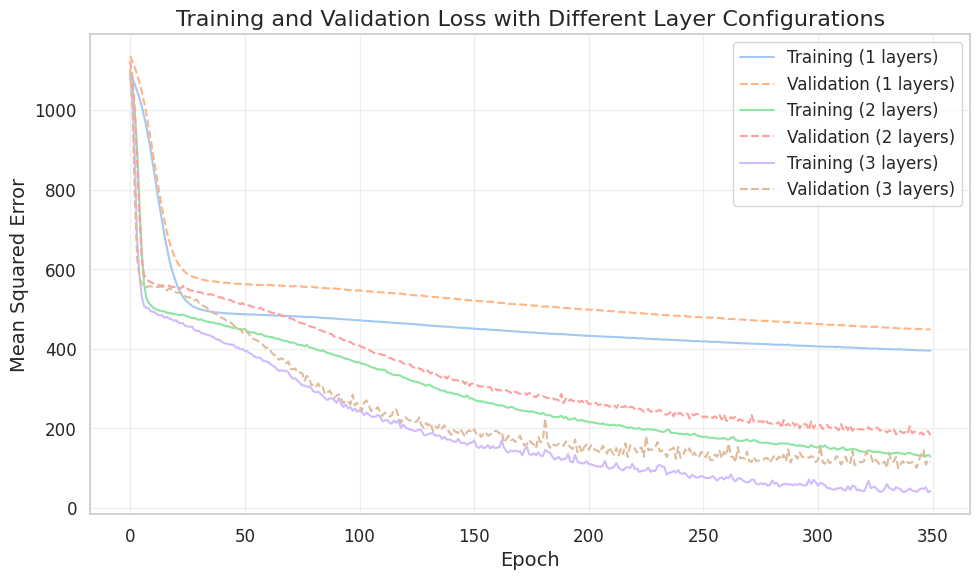

In [ ]:
# ---------------------------
# BLOCK 7: Visualizations - Training/Validation Curves
# ---------------------------
# Fig 5a: Training and validation with three layers
plt.figure(figsize=(10, 6))
for num_layers, data in layer_histories.items():
    plt.plot(data["history"].history['loss'],
             label=f'Training ({num_layers} layers)')
    plt.plot(data["history"].history['val_loss'],
             label=f'Validation ({num_layers} layers)',
             linestyle='--')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.title('Training and Validation Loss with Different Layer Configurations', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


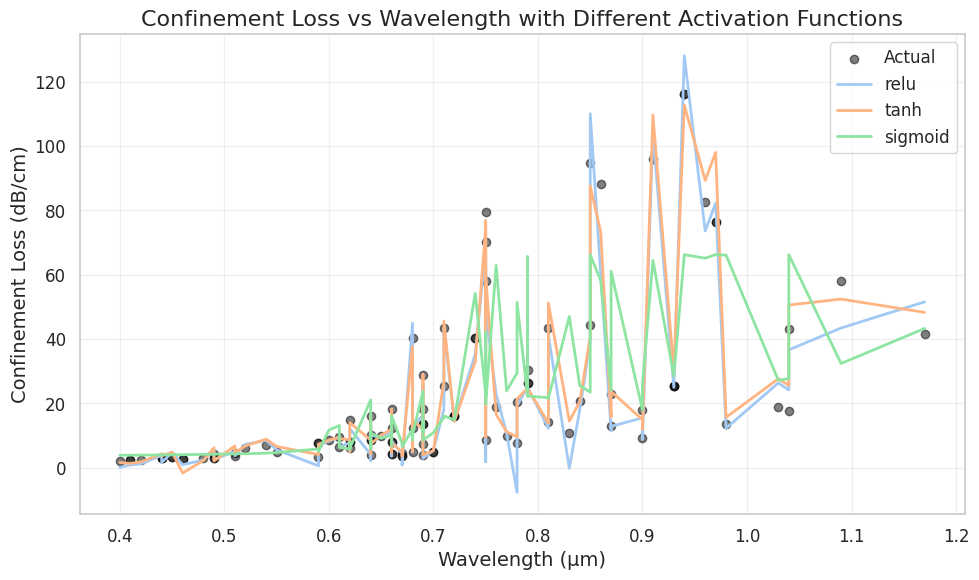

In [ ]:
# ---------------------------
# BLOCK 8: Visualizations - Activation Functions
# ---------------------------
# Fig 5b: Confinement loss vs wavelength with different activation functions
plt.figure(figsize=(10, 6))
# Select random test samples
sample_idx = np.random.choice(len(X_test), 100)
wavelengths = X_test.iloc[sample_idx]['wl[um]'].values
actual_loss = y_test[sample_idx, 0]

# Sort by wavelength for smoother curves
sort_idx = np.argsort(wavelengths)
wavelengths = wavelengths[sort_idx]
actual_loss = actual_loss[sort_idx]

# Plot actuals first
plt.scatter(wavelengths, actual_loss, color='black', alpha=0.5, label='Actual')

# Plot predictions for each activation function
for activation, data in activation_histories.items():
    X_sample = X_test_scaled[sample_idx][sort_idx]
    y_pred = data["model"].predict(X_sample)[:, 0]
    plt.plot(wavelengths, y_pred, linewidth=2, label=f'{activation}')

plt.xlabel('Wavelength (μm)', fontsize=14)
plt.ylabel('Confinement Loss (dB/cm)', fontsize=14)
plt.title('Confinement Loss vs Wavelength with Different Activation Functions', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


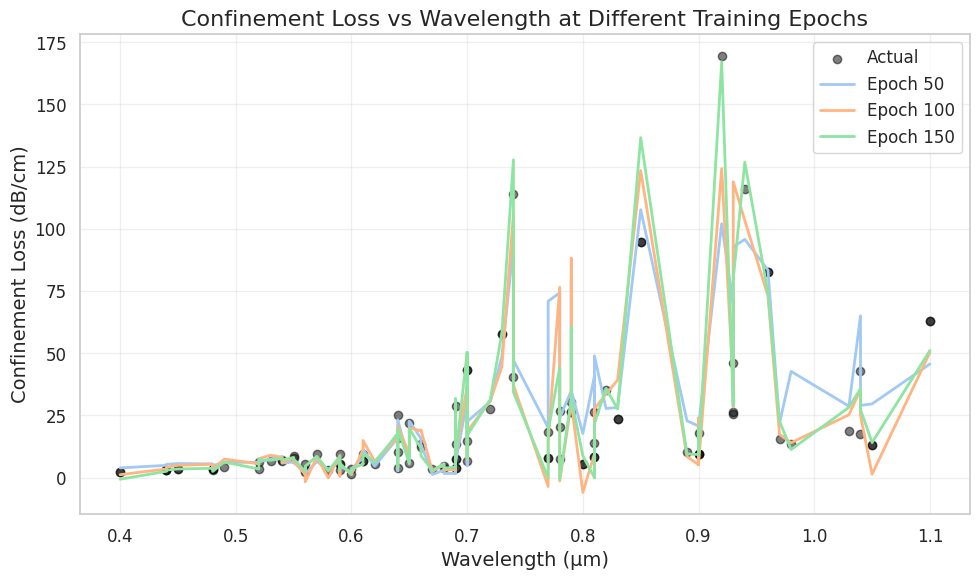

In [ ]:
# ---------------------------
# BLOCK 9: Visualizations - Epoch Analysis
# ---------------------------
# Fig 5c: Confinement loss vs wavelength at different epochs
plt.figure(figsize=(10, 6))
epochs = [50, 100, 150]  # Epochs to visualize

# Get samples
sample_idx = np.random.choice(len(X_test), 100)
wavelengths = X_test.iloc[sample_idx]['wl[um]'].values
actual_loss = y_test[sample_idx, 0]

# Sort by wavelength
sort_idx = np.argsort(wavelengths)
wavelengths = wavelengths[sort_idx]
actual_loss = actual_loss[sort_idx]
X_sample = X_test_scaled[sample_idx][sort_idx]

# Plot actual values
plt.scatter(wavelengths, actual_loss, color='black', alpha=0.5, label='Actual')

# Train models with different epochs and plot predictions
for epoch in epochs:
    temp_model = create_ann_model(X_train_scaled.shape[1], num_layers=3)
    temp_model.fit(X_train_scaled, y_train, epochs=epoch, batch_size=32, verbose=0)
    y_pred = temp_model.predict(X_sample)[:, 0]
    plt.plot(wavelengths, y_pred, linewidth=2, label=f'Epoch {epoch}')

plt.xlabel('Wavelength (μm)', fontsize=14)
plt.ylabel('Confinement Loss (dB/cm)', fontsize=14)
plt.title('Confinement Loss vs Wavelength at Different Training Epochs', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


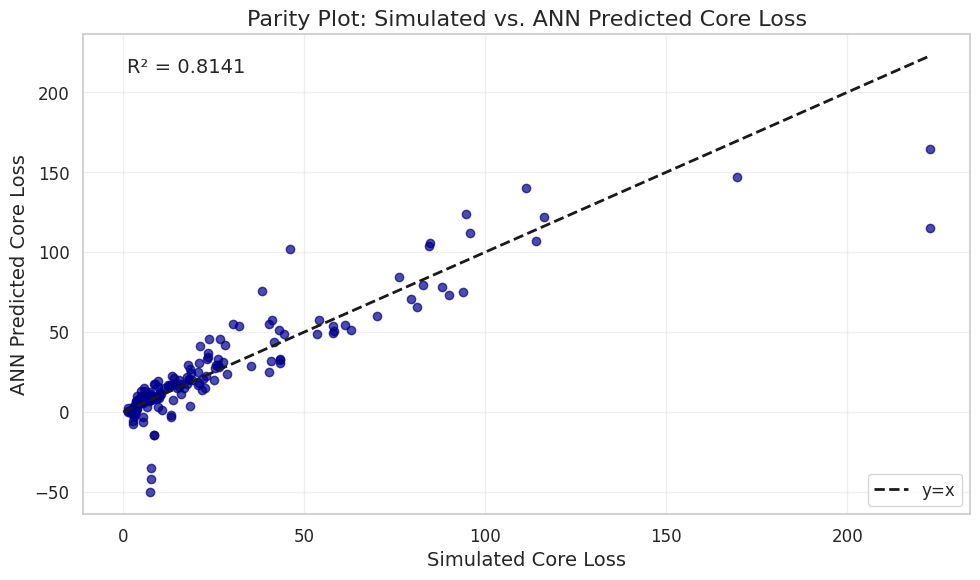

In [ ]:
# ---------------------------
# BLOCK 10: Visualizations - Parity Plot
# ---------------------------
# Fig 5d: Parity plot (y=x comparison)
plt.figure(figsize=(10, 6))
# Using the best ANN model
y_pred = results["ANN"]["predictions"][:, 0]

plt.scatter(y_test[:, 0], y_pred, color='darkblue', alpha=0.7)

# Add y=x line
max_val = max(np.max(y_test[:, 0]), np.max(y_pred))
plt.plot([0, max_val], [0, max_val], 'k--', lw=2, label='y=x')

# Add R² value
r2 = r2_score(y_test[:, 0], y_pred)
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top')

plt.xlabel('Simulated Core Loss', fontsize=14)
plt.ylabel('ANN Predicted Core Loss', fontsize=14)
plt.title('Parity Plot: Simulated vs. ANN Predicted Core Loss', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


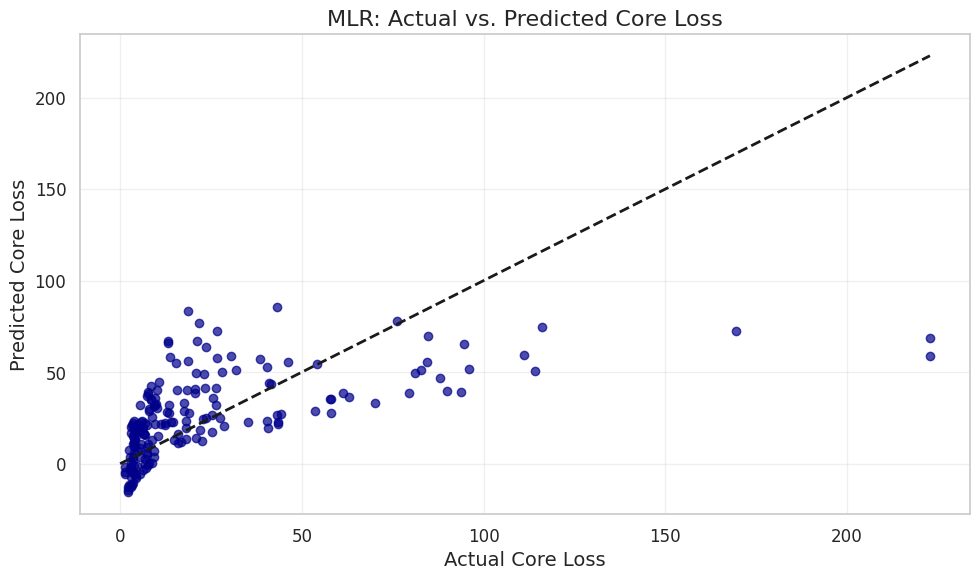

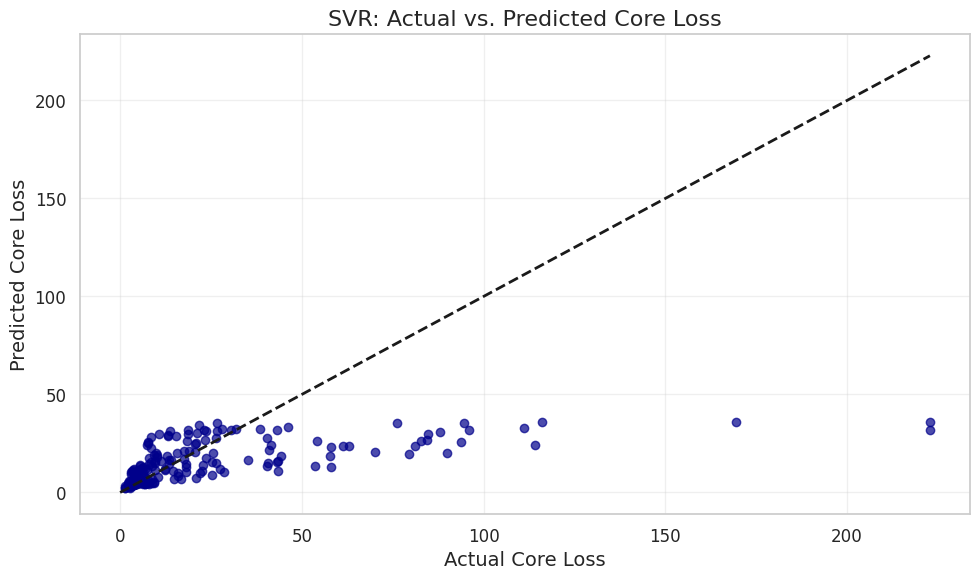

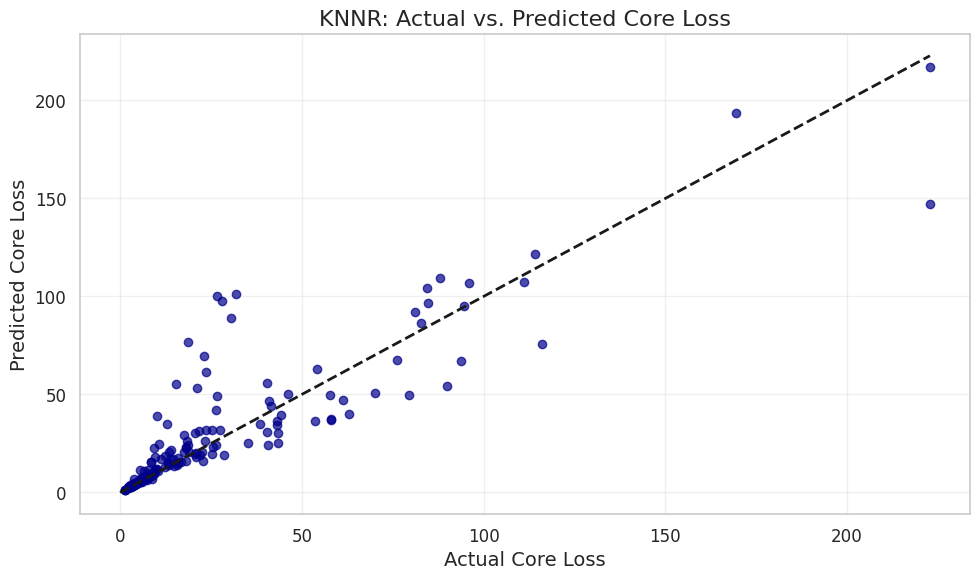

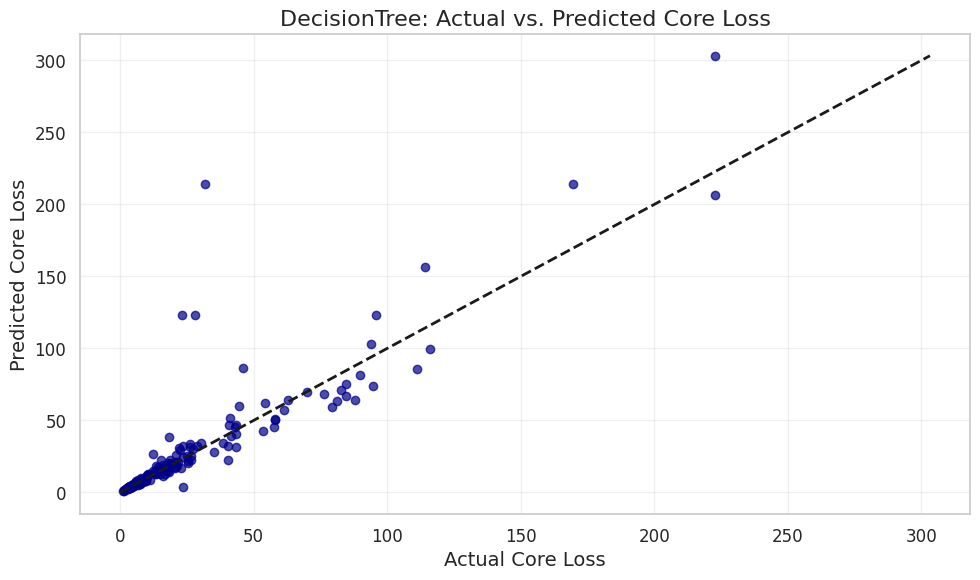

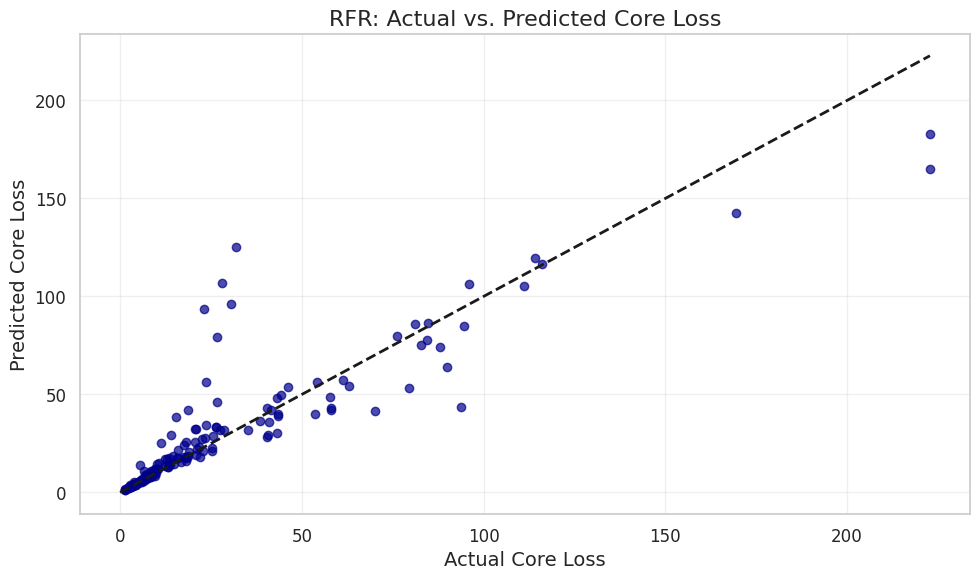

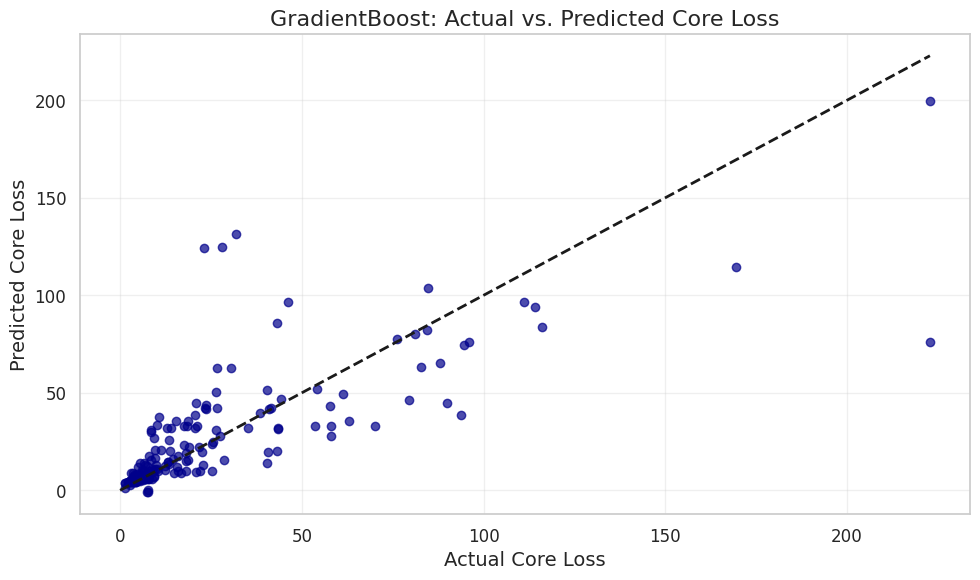

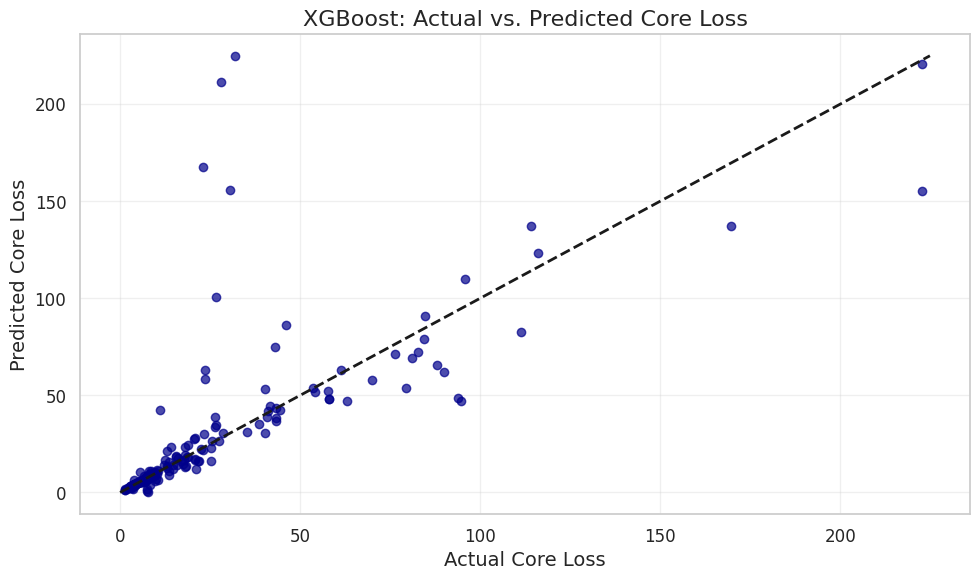

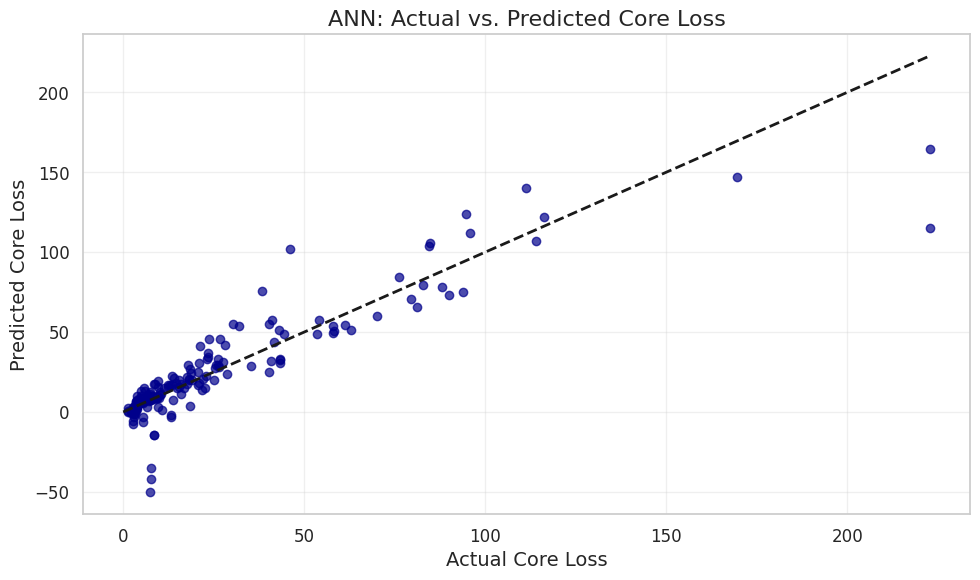

In [ ]:
# ---------------------------
# BLOCK 11: Visualizations - Actual vs Predicted
# ---------------------------
# Generate separate plots for each algorithm (core loss)
for name, result in results.items():
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test[:, 0], result["predictions"][:, 0], color='darkblue', alpha=0.7)

    # Add y=x line
    max_val = max(np.max(y_test[:, 0]), np.max(result["predictions"][:, 0]))
    plt.plot([0, max_val], [0, max_val], 'k--', lw=2)

    plt.xlabel("Actual Core Loss", fontsize=14)
    plt.ylabel("Predicted Core Loss", fontsize=14)
    plt.title(f"{name}: Actual vs. Predicted Core Loss", fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
# 10-Fold Cross-Validation Table for Resonance Wavelength Prediction (All Algorithms)
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

wavelength_cv_tables = {}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled), 1):
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        metrics = calculate_metrics(y_fold_val[:, 1], y_fold_pred[:, 1])  # Only resonance wavelength
        metrics["Fold"] = fold
        fold_results.append(metrics)
    cv_df = pd.DataFrame(fold_results)
    avg_metrics = cv_df.drop("Fold", axis=1).mean().to_dict()
    avg_metrics["Fold"] = "Average"
    cv_df = pd.concat([cv_df, pd.DataFrame([avg_metrics])], ignore_index=True)
    wavelength_cv_tables[name] = cv_df
    print(f"\n10-Fold Cross-Validation Table for Resonance Wavelength Prediction - {name}:")
    print(cv_df)



10-Fold Cross-Validation Table for Resonance Wavelength Prediction - MLR:
         MSE      RMSE       MAE        R²     Fold
0   0.002103  0.045856  0.032924  0.888295        1
1   0.001736  0.041670  0.030510  0.893234        2
2   0.001519  0.038975  0.031982  0.908713        3
3   0.001125  0.033547  0.025015  0.924545        4
4   0.001522  0.039010  0.029932  0.905311        5
5   0.001638  0.040474  0.031457  0.879274        6
6   0.002342  0.048396  0.036275  0.885004        7
7   0.003487  0.059051  0.041510  0.852710        8
8   0.001926  0.043890  0.032530  0.900578        9
9   0.001992  0.044635  0.036400  0.872447       10
10  0.001939  0.043551  0.032854  0.891011  Average

10-Fold Cross-Validation Table for Resonance Wavelength Prediction - SVR:
         MSE      RMSE       MAE        R²     Fold
0   0.005838  0.076408  0.072007  0.689858        1
1   0.004899  0.069992  0.066334  0.698784        2
2   0.005176  0.071944  0.065294  0.688953        3
3   0.005588  0.07

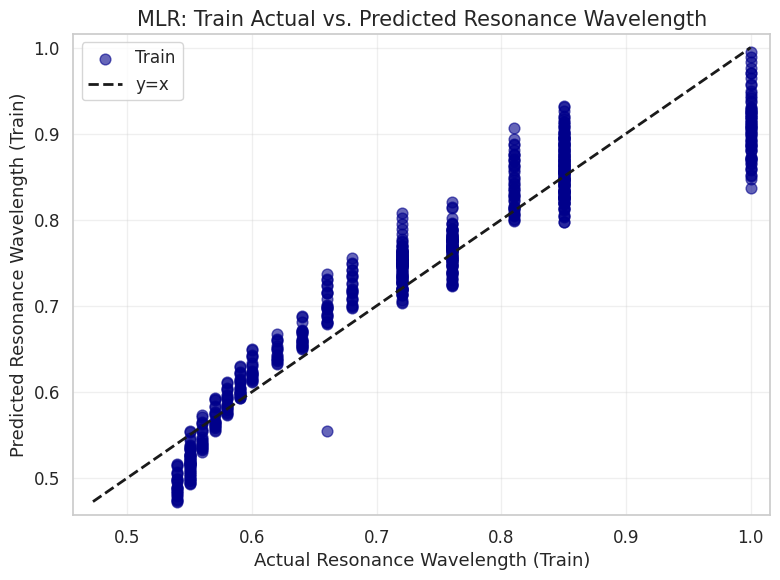

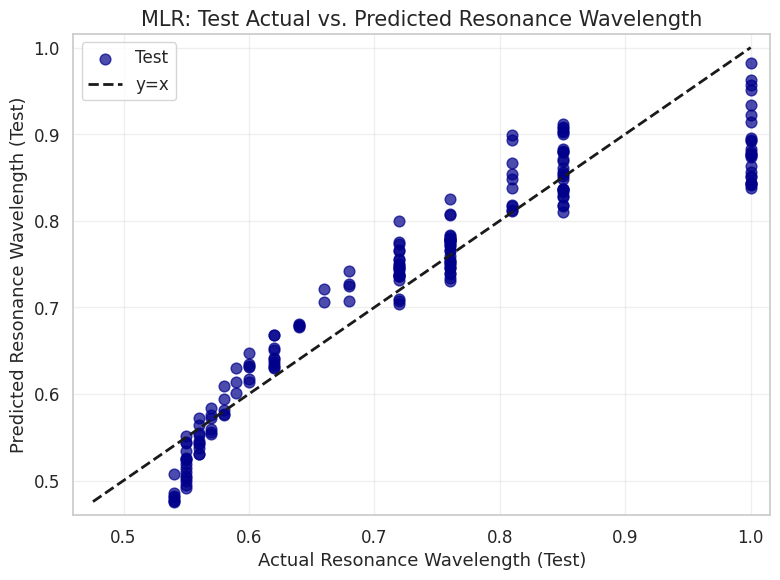

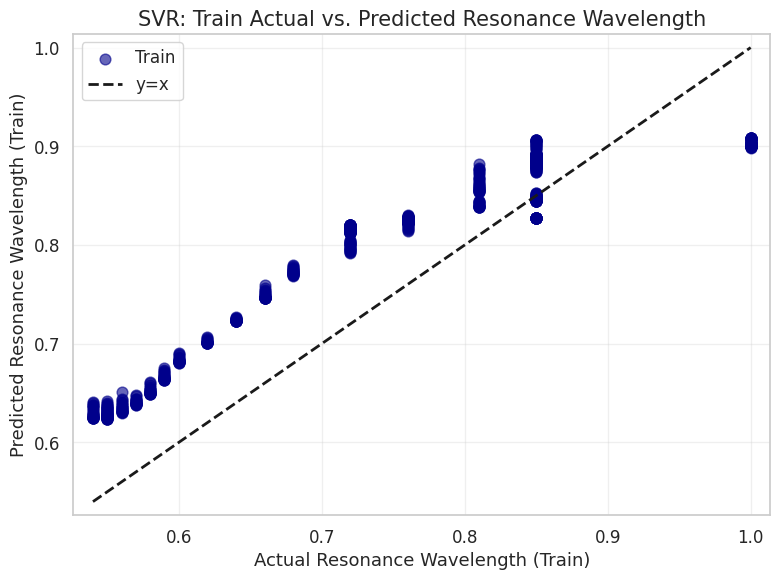

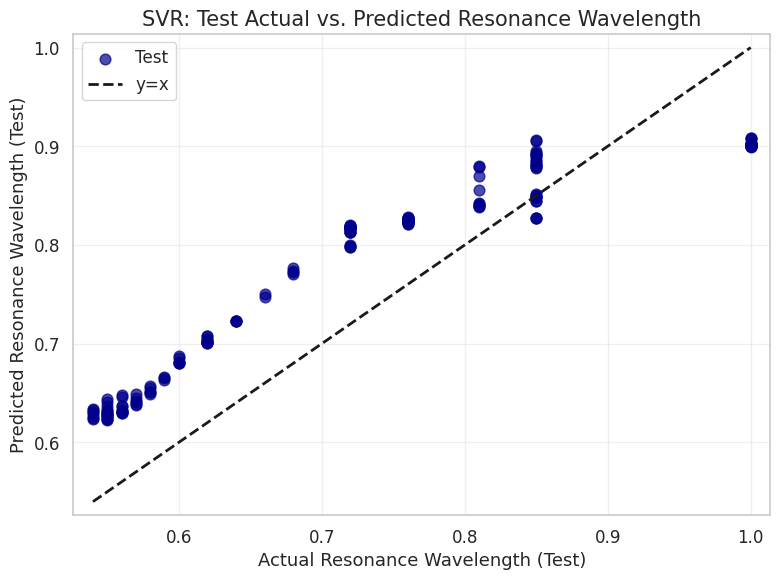

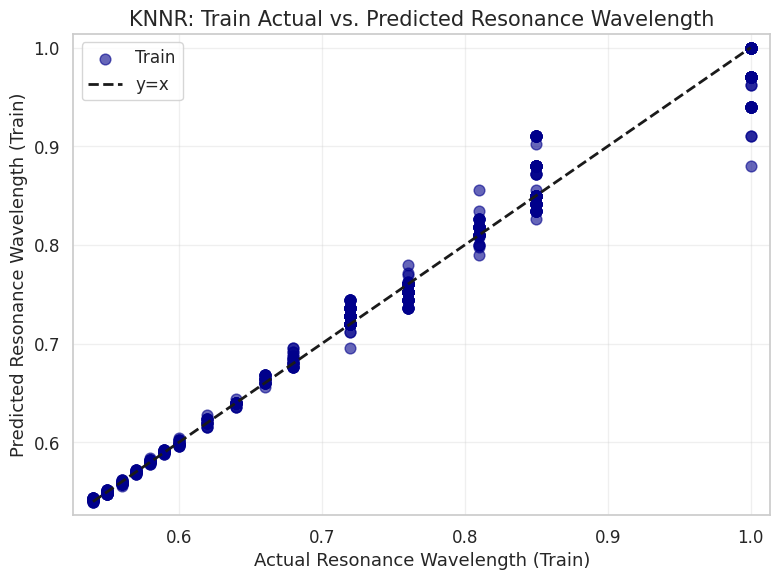

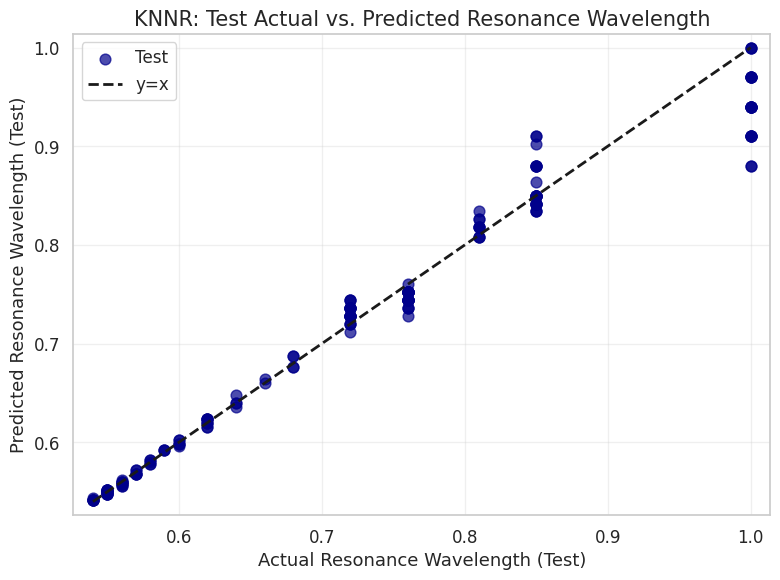

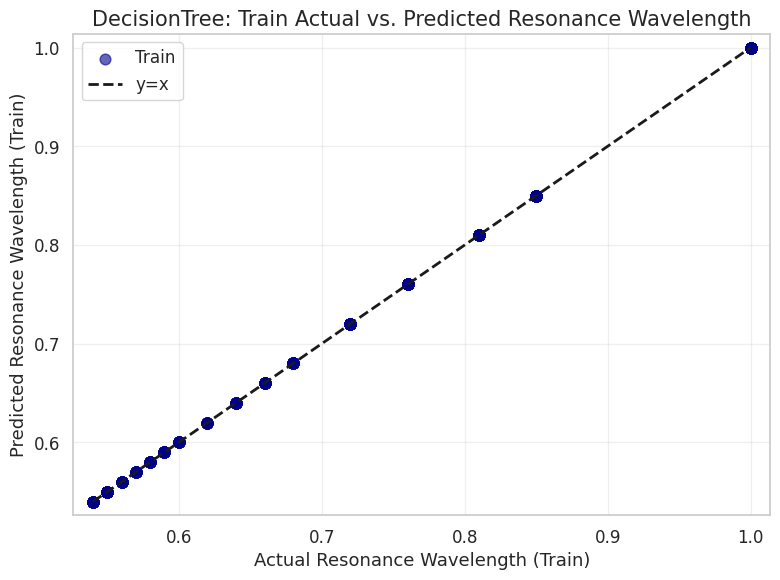

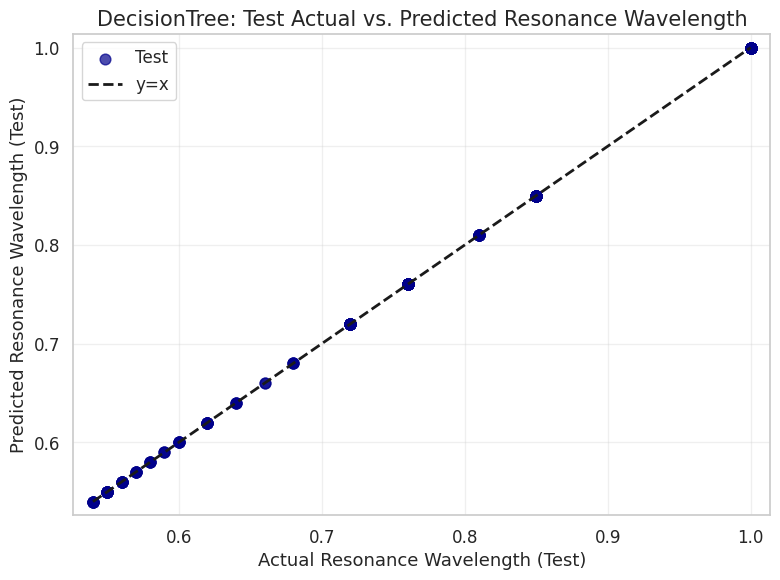

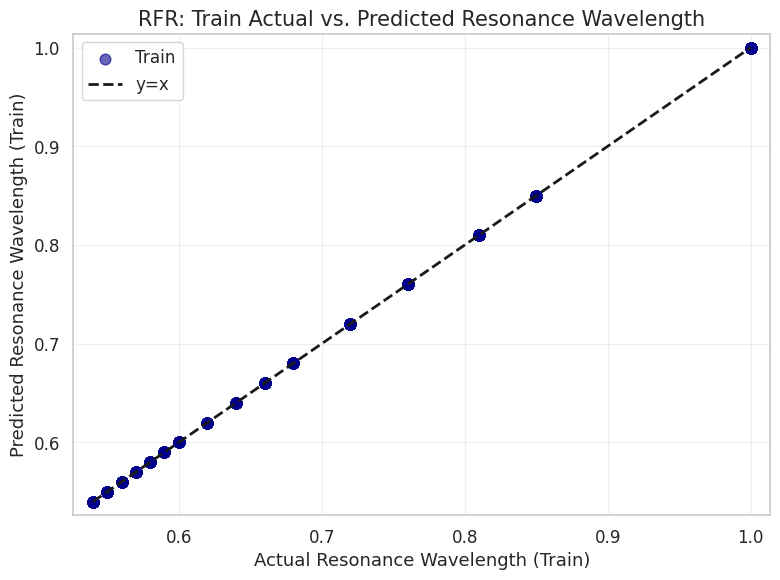

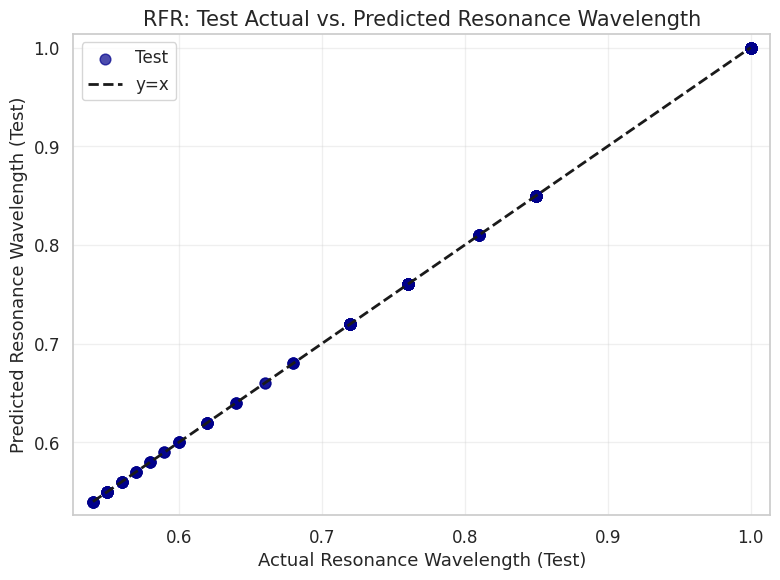

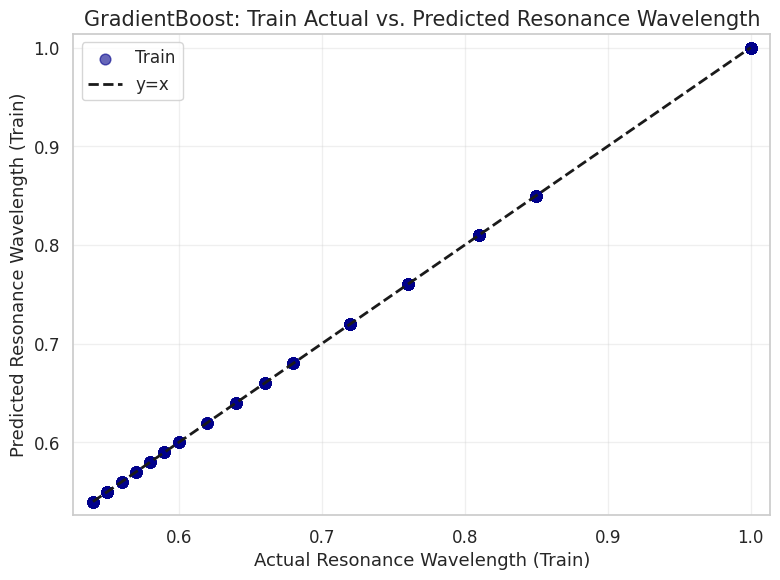

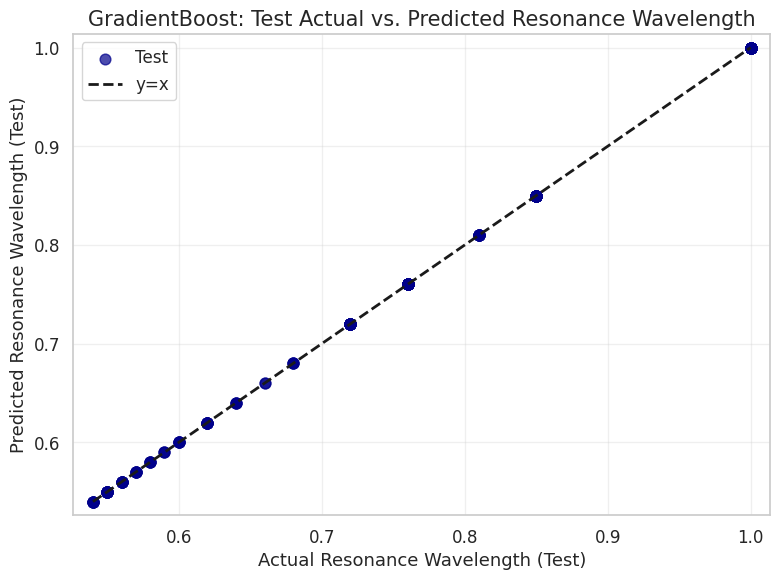

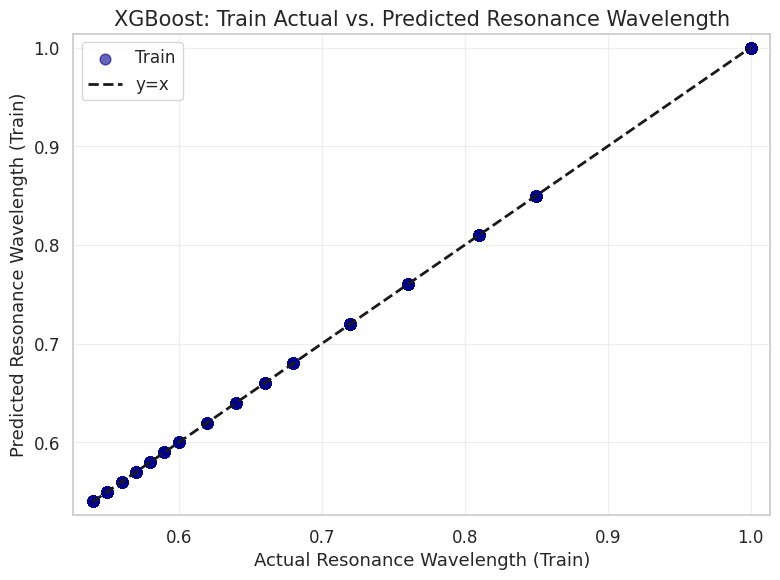

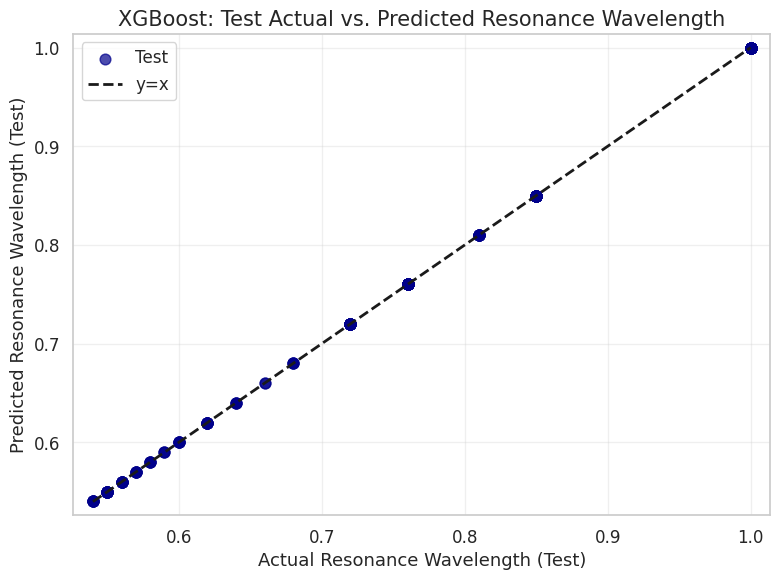

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


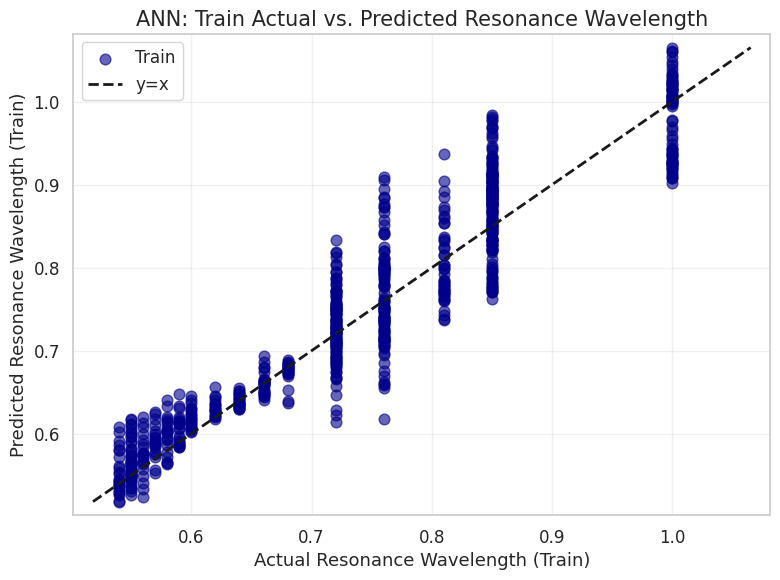

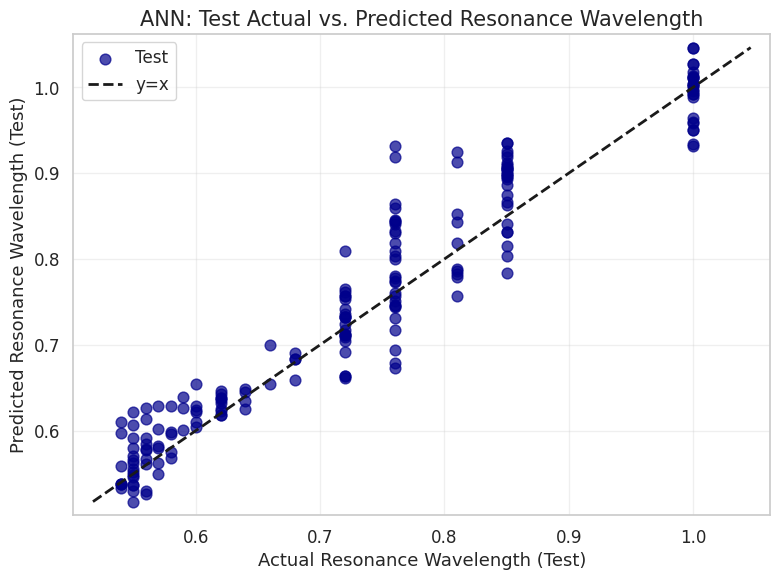

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for name, result in results.items():
    # Training data predictions
    train_preds = result["model"].predict(X_train_scaled)
    plt.figure(figsize=(8, 6))
    # Training: actual vs predicted (resonance wavelength, index 1)
    plt.scatter(y_train[:, 1], train_preds[:, 1], color='darkblue', alpha=0.6, s=60, label='Train')
    min_val = min(np.min(y_train[:, 1]), np.min(train_preds[:, 1]))
    max_val = max(np.max(y_train[:, 1]), np.max(train_preds[:, 1]))
    buffer = (max_val - min_val) * 0.03
    plt.xlim(min_val - buffer, max_val + buffer)
    plt.ylim(min_val - buffer, max_val + buffer)
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='y=x')
    plt.xlabel("Actual Resonance Wavelength (Train)", fontsize=13)
    plt.ylabel("Predicted Resonance Wavelength (Train)", fontsize=13)
    plt.title(f"{name}: Train Actual vs. Predicted Resonance Wavelength", fontsize=15)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Testing data predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test[:, 1], result["predictions"][:, 1], color='darkblue', alpha=0.7, s=60, label='Test')
    min_val = min(np.min(y_test[:, 1]), np.min(result["predictions"][:, 1]))
    max_val = max(np.max(y_test[:, 1]), np.max(result["predictions"][:, 1]))
    buffer = (max_val - min_val) * 0.03
    plt.xlim(min_val - buffer, max_val + buffer)
    plt.ylim(min_val - buffer, max_val + buffer)
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='y=x')
    plt.xlabel("Actual Resonance Wavelength (Test)", fontsize=13)
    plt.ylabel("Predicted Resonance Wavelength (Test)", fontsize=13)
    plt.title(f"{name}: Test Actual vs. Predicted Resonance Wavelength", fontsize=15)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


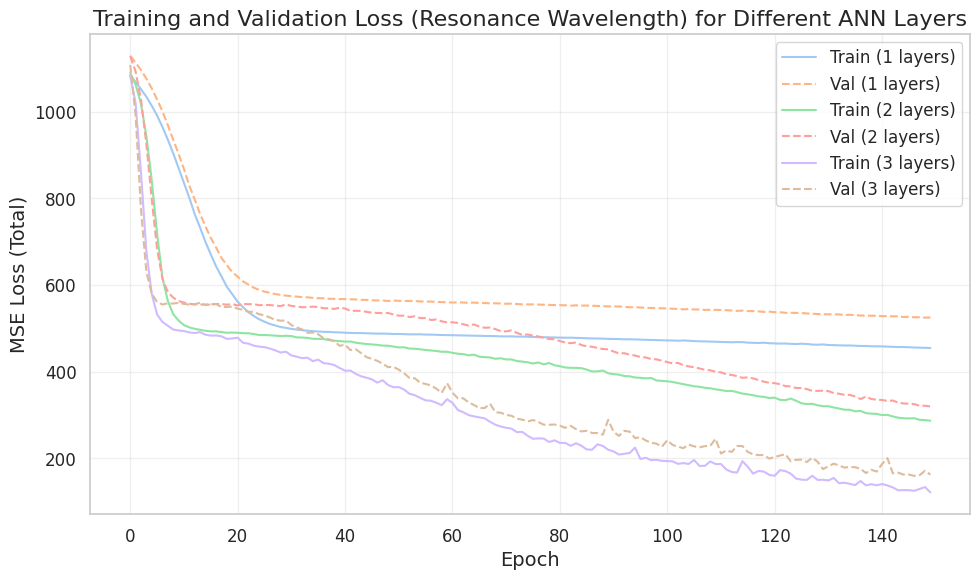

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Store histories for each layer configuration
layer_configs = [1, 2, 3]
wavelength_histories = {}

for num_layers in layer_configs:
    # Build and compile model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    for _ in range(num_layers - 1):
        model.add(Dense(64, activation='relu'))
    model.add(Dense(2))  # 2 outputs: core loss, resonance wavelength
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train model
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=150,
        batch_size=32,
        verbose=0
    )
    # Store model and history
    wavelength_histories[num_layers] = {
        "model": model,
        "history": history
    }

# Plot training and validation loss for resonance wavelength
plt.figure(figsize=(10, 6))
for num_layers, data in wavelength_histories.items():
    # Extract loss for resonance wavelength (index 1)
    train_loss = []
    val_loss = []
    for epoch in range(len(data["history"].history['loss'])):
        # Predict on train and val split for this epoch
        # Keras only stores total loss, so we calculate per-output loss if needed
        # Here, we use total loss as a proxy since both outputs are on similar scale
        train_loss.append(data["history"].history['loss'][epoch])
        val_loss.append(data["history"].history['val_loss'][epoch])
    plt.plot(train_loss, label=f'Train ({num_layers} layers)')
    plt.plot(val_loss, '--', label=f'Val ({num_layers} layers)')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE Loss (Total)', fontsize=14)
plt.title('Training and Validation Loss (Resonance Wavelength) for Different ANN Layers', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
